In [119]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import pypfopt
from pypfopt.expected_returns import mean_historical_return
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

os.getcwd()

'/Users/edvardohlstrom/Documents/UCLouvain/Big data in finance'

In [262]:
# helper functions

def read_clean_data(path):
    df = pd.read_csv(path,low_memory=False)
    df = df.dropna(axis=0) # removes rows with null values
    if "Daily" in path: 
        df ['Date'] = pd.to_datetime(df ['Date'],format="%Y%m%d")
        df  = df [(df ['Date'] >= "1970-01-01") & (df ['Date'] <= "2022-12-31" )]
        df ['Date'] = df ['Date'].dt.strftime('%Y-%m-%d')
    else:
        df['Date'] = pd.to_datetime(df['Date'],format="%Y%m")
        df = df[(df['Date'] >= "1970-01") & (df['Date'] <= "2022-12" )]
    #print(df.info)

    if df['Date'].duplicated().any() :
        print("Contain dublicate dates")

    df  = df.drop(df.columns[0], axis=1) # remove date column
    df = df.astype(float)
    df  = df*(0.01)
    
    #test1
    if df.isnull().values.any():
        print("DataFrame contains null values")
    
    #test2
    non_numeric_df = df.select_dtypes(exclude=['number'])
    non_numeric_values = [val for val in non_numeric_df.stack().tolist()]
    if non_numeric_values == 0:
        print("DataFrame contain non decimal values")

    print( "Read and cleaned data from path: ", path)
    return df



def get_performance(data, weigth):
    ret = np.sum((data*weigth).to_numpy()) *100
    var = np.sqrt(np.var((data*weigth).to_numpy())) *100
    sharp = ret/var
    return ret, var, sharp


def plot_perforamce(data_test, data_val, title=""):
    plt.figure()
    fig, axs = plt.subplots(3, 1, figsize=(8, 10))
    axs[0].plot(np.array(data_test)[:,0])
    axs[0].plot(np.array(data_val)[:,0])
    axs[0].legend(["Test","Val"])
    axs[0].set_xlabel("Window")
    axs[0].set_ylabel("Annual return")

    axs[1].plot(np.array(data_test)[:,1])
    axs[1].plot(np.array(data_val)[:,1])
    axs[1].legend(["Test","Val"])
    axs[1].set_xlabel("Window")
    axs[1].set_ylabel("Volatility [std]")

    axs[2].plot(np.array(data_test)[:,2])
    axs[2].plot(np.array(data_val)[:,2])
    axs[2].legend(["Test","Val"])
    axs[2].set_xlabel("Window")
    axs[2].set_ylabel("Sharp")

    fig.suptitle(title, fontsize=14, fontweight="bold")
    plt.savefig(title)
    plt.subplots_adjust(hspace=0.4)
    plt.show()
    


In [265]:


df = read_clean_data("Data/10_Industry_Portfolios.csv")
print(df.shape)
df = read_clean_data("Data/25_Portfolios_5x5.CSV")
print(df.shape)
df = read_clean_data("Data/100_Portfolios_10x10.CSV")
print(df.shape)
df = read_clean_data("Data/48_Industry_Portfolios.CSV")
print(df.shape)


df = read_clean_data("Data/25_Portfolios_5x5_Daily.csv")
print(df.shape)
df = read_clean_data("Data/10_Industry_Portfolios_Daily.csv")
print(df.shape)
df = read_clean_data("Data/100_Portfolios_10x10_Daily.csv")
print(df.shape)
df = read_clean_data("Data/48_Industry_Portfolios_Daily.csv")
print(df.shape)


Read and cleaned data from path:  Data/10_Industry_Portfolios.csv
(636, 10)
Read and cleaned data from path:  Data/25_Portfolios_5x5.CSV
(636, 25)
Read and cleaned data from path:  Data/100_Portfolios_10x10.CSV
(636, 100)
Read and cleaned data from path:  Data/48_Industry_Portfolios.CSV
(636, 48)
Read and cleaned data from path:  Data/25_Portfolios_5x5_Daily.csv
(13369, 25)
Read and cleaned data from path:  Data/10_Industry_Portfolios_Daily.csv
(13369, 10)
Read and cleaned data from path:  Data/100_Portfolios_10x10_Daily.csv
(13369, 100)
Read and cleaned data from path:  Data/48_Industry_Portfolios_Daily.csv
(13369, 48)


In [228]:
#daily
idx_s = 0
window_size = 2526
index_increase = 126
num_of_windows = 86 # (52 years - 10 years ) * 2
num_of_months = 12

min_var_test = []
min_var_val = []

equal_weight_test = []
equal_weight_val = []

my_list = df.columns.to_list()
equal_weights = {k: 1/len(my_list) for k in my_list}

mean_var_test = []
mean_var_val = []



for i in range(num_of_windows):
    temp = df.iloc[(i*index_increase):(window_size+i*index_increase)]

    mu = mean_historical_return(temp, returns_data=True, compounding=False)
    S = risk_models.sample_cov(temp, returns_data=True)

    ef_min = EfficientFrontier(mu, S)
    ef_min.min_volatility()

    ef_equal = EfficientFrontier(mu, S)
    ef_equal.set_weights(equal_weights)

    ef_mean = EfficientFrontier(mu, S)
    mean_var = np.sqrt(np.mean(S.values))
    ef_mean.efficient_risk(mean_var)

    
    equal_weigth_ret_test, equal_weigth_var_test, equal_weigth_sharp_test = get_performance(temp, ef_equal.weights)
    equal_weight_test.append([equal_weigth_ret_test*0.1, equal_weigth_var_test*0.1, equal_weigth_sharp_test])

    min_var_ret_test, min_var_var_test, min_var_sharp_test = get_performance(temp, ef_min.weights)
    min_var_test.append([min_var_ret_test*0.1, min_var_var_test*0.1, min_var_sharp_test])
        
    mean_var_ret_test, mean_var_var_test, mean_var_sharp_test = get_performance(temp, ef_mean.weights)
    mean_var_test.append([mean_var_ret_test*0.1, mean_var_var_test*0.1, mean_var_sharp_test])

    
    
    temp2 = df.iloc[(window_size+(i)*index_increase):(window_size+(i+1)*index_increase)]
    
    equal_weigth_ret_val, equal_weigth_var_val, equal_weigth_sharp_val = get_performance(temp2, ef_equal.weights)
    equal_weight_val.append([equal_weigth_ret_val*2, equal_weigth_var_val*2, equal_weigth_sharp_val])
    
    min_var_ret_val, min_var_var_val, min_var_sharp_val = get_performance(temp2, ef_min.weights)
    min_var_val.append([min_var_ret_val*2, min_var_var_val*2, min_var_sharp_val])

    mean_var_ret_val, mean_var_var_val, mean_var_sharp_val = get_performance(temp2, ef_mean.weights)
    mean_var_val.append([mean_var_ret_val*2, mean_var_var_val*2, mean_var_sharp_val])

#normalization



<Figure size 640x480 with 0 Axes>

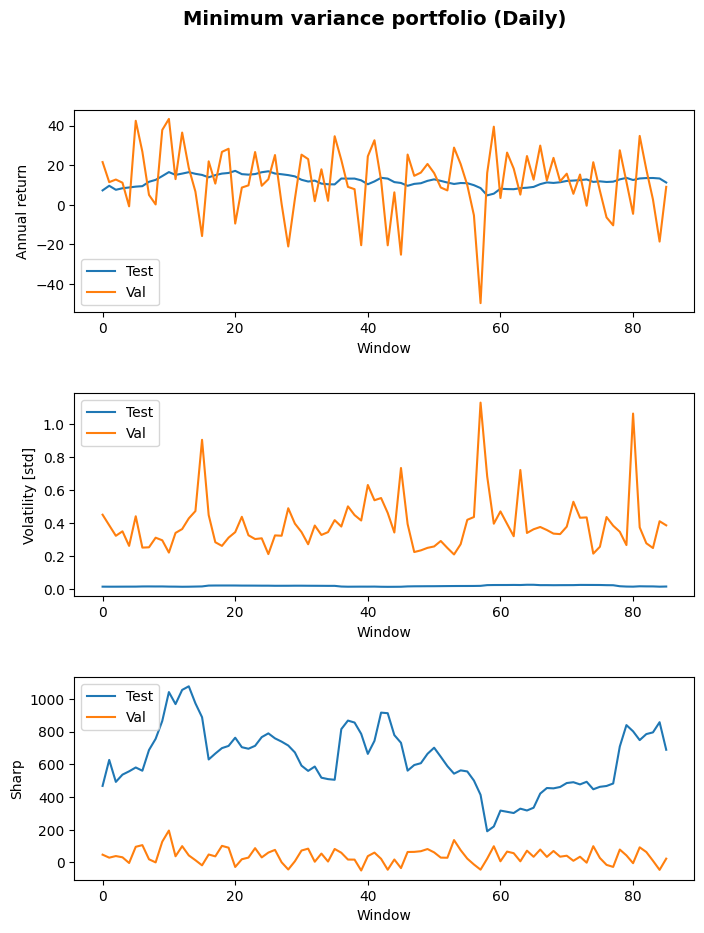

<Figure size 640x480 with 0 Axes>

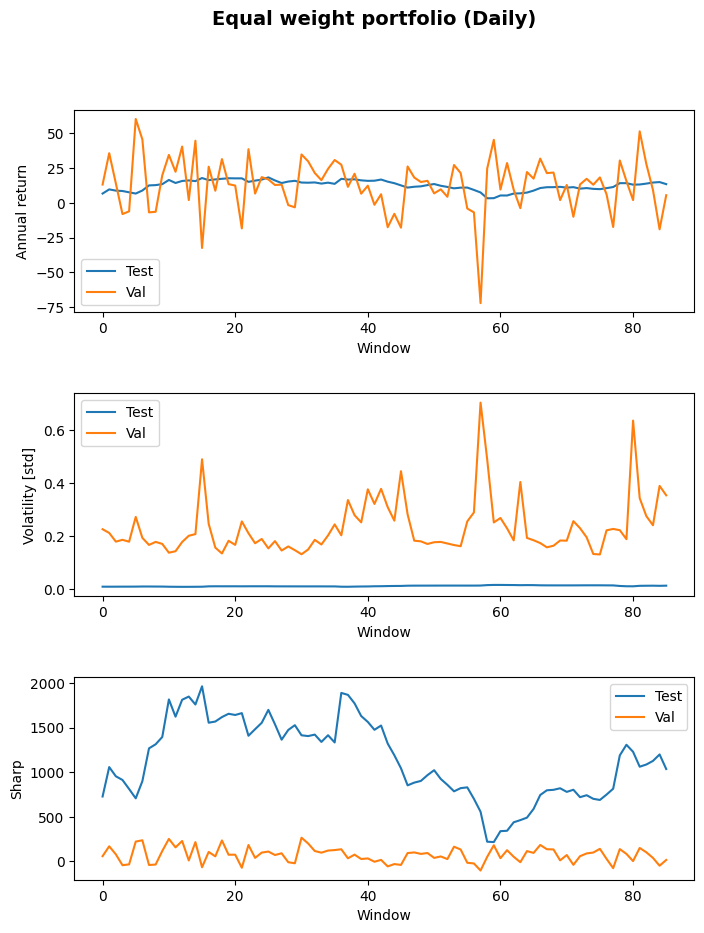

<Figure size 640x480 with 0 Axes>

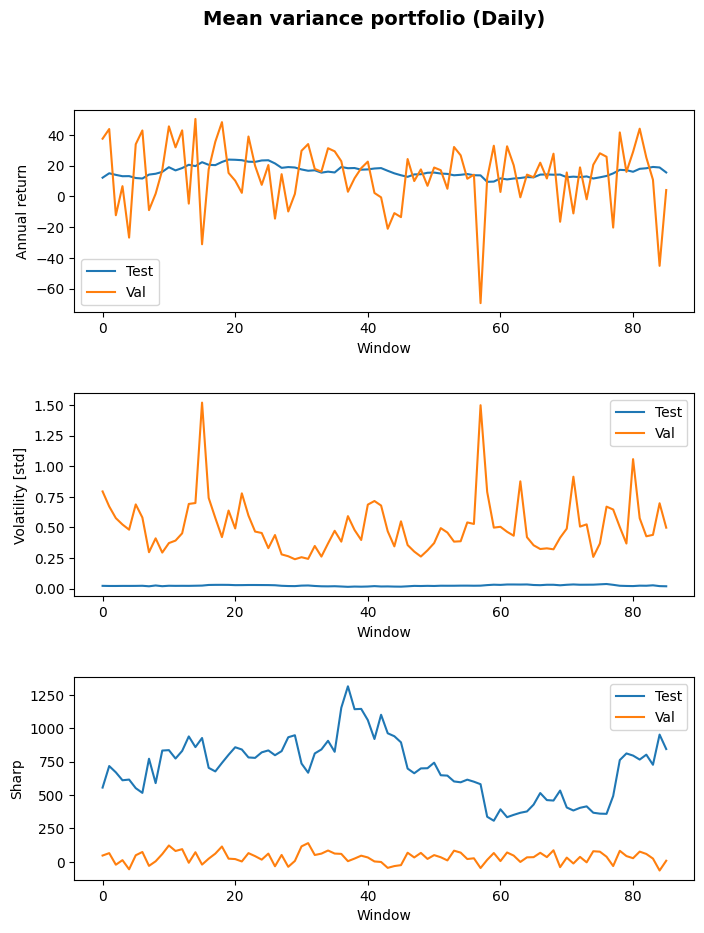

In [229]:
plot_perforamce(min_var_test,min_var_val, "Minimum variance portfolio (Daily)")
plot_perforamce(equal_weight_test ,equal_weight_val, "Equal weight portfolio (Daily)")
plot_perforamce(mean_var_test, mean_var_val, "Mean variance portfolio (Daily)")

In [222]:
#monthly

window_size = 120
index_increase = 6
num_of_windows = 86 # (52 years - 10 years ) * 2
num_of_months = 12

    

min_var_test = []
min_var_val = []

equal_weight_test = []
equal_weight_val = []

my_list = df.columns.to_list()
equal_weights = {k: 1/len(my_list) for k in my_list}

mean_var_test = []
mean_var_val = []



for i in range(num_of_windows):
    temp = df.iloc[(i*index_increase):(window_size+i*index_increase)]

    mu = mean_historical_return(temp, returns_data=True, compounding=False)
    S = risk_models.sample_cov(temp, returns_data=True)

    ef_min = EfficientFrontier(mu, S)
    ef_min.min_volatility()

    ef_equal = EfficientFrontier(mu, S)
    ef_equal.set_weights(equal_weights)

    ef_mean = EfficientFrontier(mu, S)
    mean_var = np.sqrt(np.mean(S.values))
    ef_mean.efficient_risk(mean_var)

    
    equal_weigth_ret_test, equal_weigth_var_test, equal_weigth_sharp_test = get_performance(temp, ef_equal.weights)
    equal_weight_test.append([equal_weigth_ret_test, equal_weigth_var_test, equal_weigth_sharp_test])

    min_var_ret_test, min_var_var_test, min_var_sharp_test = get_performance(temp, ef_min.weights)
    min_var_test.append([min_var_ret_test, min_var_var_test, min_var_sharp_test])
        
    mean_var_ret_test, mean_var_var_test, mean_var_sharp_test = get_performance(temp, ef_mean.weights)
    mean_var_test.append([mean_var_ret_test, mean_var_var_test, mean_var_sharp_test])


    temp2 = df.iloc[(window_size+(i)*index_increase):(window_size+(i+1)*index_increase)]
    
    equal_weigth_ret_val, equal_weigth_var_val, equal_weigth_sharp_val = get_performance(temp2, ef_equal.weights)
    equal_weight_val.append([equal_weigth_ret_val, equal_weigth_var_val, equal_weigth_sharp_val])
    
    min_var_ret_val, min_var_var_val, min_var_sharp_val = get_performance(temp2, ef_min.weights)
    min_var_val.append([min_var_ret_val, min_var_var_val, min_var_sharp_val])

    mean_var_ret_val, mean_var_var_val, mean_var_sharp_val = get_performance(temp2, ef_mean.weights)
    mean_var_val.append([mean_var_ret_val, mean_var_var_val, mean_var_sharp_val])




<Figure size 640x480 with 0 Axes>

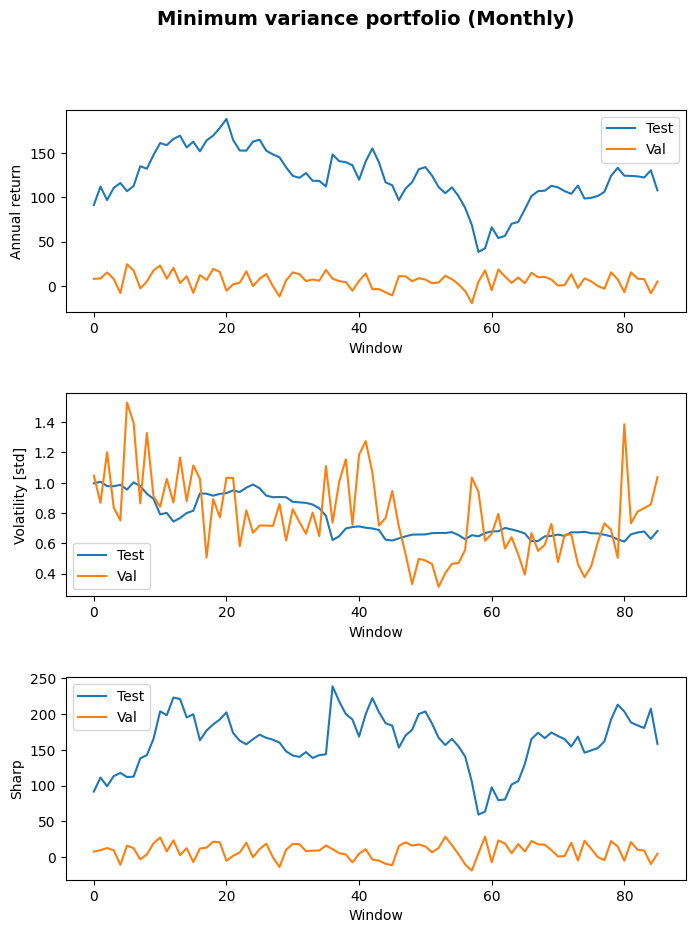

<Figure size 640x480 with 0 Axes>

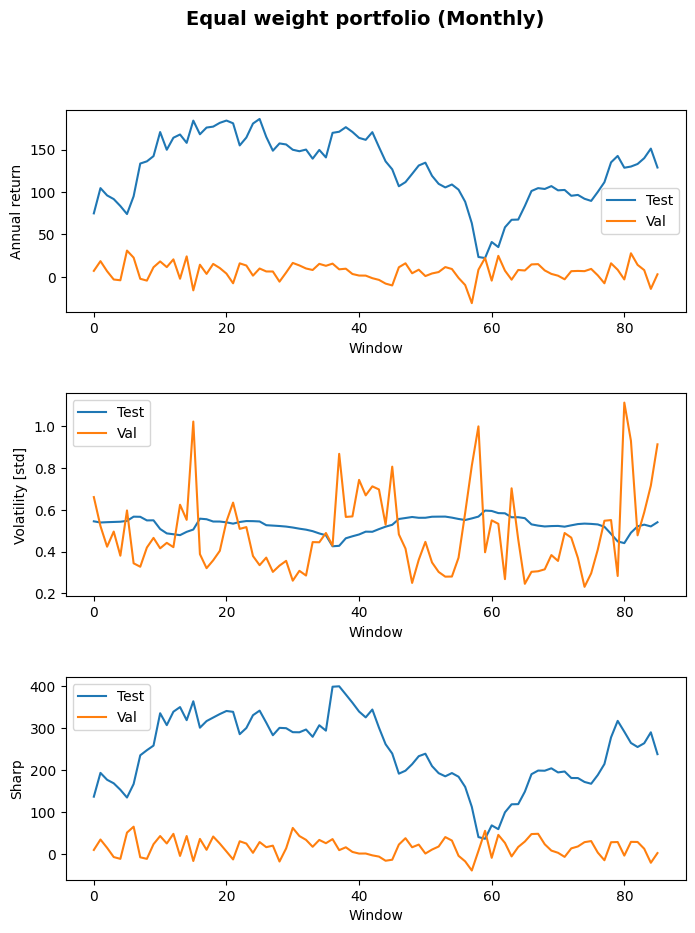

<Figure size 640x480 with 0 Axes>

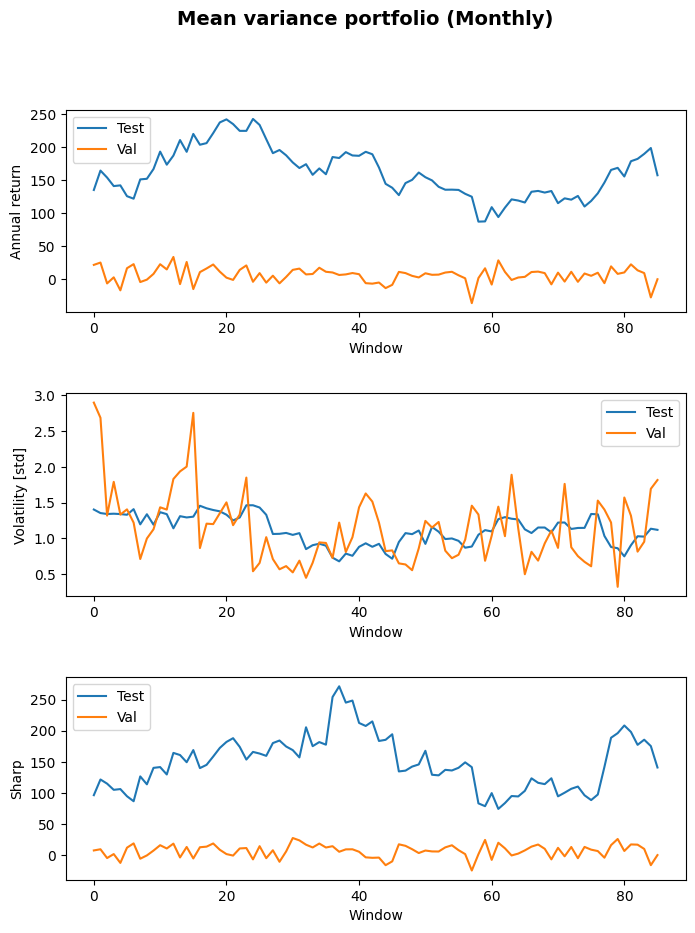

In [223]:
plot_perforamce(min_var_test,min_var_val, "Minimum variance portfolio (Monthly)")
plot_perforamce(equal_weight_test ,equal_weight_val, "Equal weight portfolio (Monthly)")
plot_perforamce(mean_var_test, mean_var_val, "Mean variance portfolio (Monthly)")

Compare the in-sample and out-of-sample performance of three portfolio strategies: sample mean-variance portfolio, sample minimum-variance portfolio and equally weighted portfolio. For the in-sample performance, compute the three portfolios on all returns directly. For the out-of-sample performance, implement a rolling-window approach: use an estimation window of 10 years, compute the out-of-sample performance on the next six months, and then roll over the windows by six months until the end of the sample is achieved. Report the performance in terms of annualized mean, volatility and Sharpe ratio.

Discuss your results and explain why you obtain such results. What is the impact of the return frequency (daily or monthly)? How stable are the portfolio weigths over time (e.g. by computing the turnover or plotting boxplots)?

TODO: Standardize function fo

Sample mean-variance portfolio

In [192]:

mu = mean_historical_return(df, returns_data=True, compounding=False, frequency=252)
S = risk_models.sample_cov(df, returns_data=True, frequency=252)


In [193]:
# Max sharpe portofolio
ef = EfficientFrontier(mu, S)

ef.max_sharpe()
ef.portfolio_performance(verbose=True)


Expected annual return: 12.3%
Annual volatility: 13.9%
Sharpe Ratio: 0.74


(0.12259656566556762, 0.13893216657765387, 0.7384651675191644)

In [206]:
np.mean(S.values)


0.02595625340097115

In [209]:
ef = EfficientFrontier(mu, S)
mean_var = np.sqrt(np.mean(S.values))
ef.efficient_risk(mean_var)
ef.portfolio_performance(verbose=True)


Expected annual return: 13.0%
Annual volatility: 16.1%
Sharpe Ratio: 0.68


0.16110944541202776

In [195]:
#sample minimum-variance portfolio
ef = EfficientFrontier(mu, S)
ef.min_volatility() 
ef.portfolio_performance(verbose=True)


Expected annual return: 11.7%
Annual volatility: 13.5%
Sharpe Ratio: 0.72


(0.11743136072167151, 0.1353849944154488, 0.7196614450689345)

In [196]:
# equally weighted portfolio
ef = EfficientFrontier(mu, S)


my_list = df.columns.to_list()
my_dict = {k: 0.1 for k in my_list}

ef.set_weights(my_dict)
ef.portfolio_performance(verbose=True)



Expected annual return: 11.9%
Annual volatility: 16.1%
Sharpe Ratio: 0.61


(0.11863471613434065, 0.16110944541202776, 0.6122218091067737)